In [1]:
from __future__ import division

import time
import gzip

import numpy as np
import scipy.io as sio
import matplotlib.pyplot as plt
%matplotlib inline

plt.set_cmap("gray")
plt.rcParams["image.interpolation"] = None

import TN_utils
reload(TN_utils)

<module 'TN_utils' from 'TN_utils.pyc'>

In [2]:
feature_vec_36 = TN_utils.load_featureImg_r(1)
feature_vec_12 = TN_utils.load_featureImg_r(12)

with gzip.open("../data/toytreerot_imgGT.npy.gz", "r") as f:
    GT_vec_array = np.load(f)
GT_vec_36 = GT_vec_array[0]
GT_vec_12 = GT_vec_array[11]

with gzip.open("../data/toytreerot_mask.npy.gz", "r") as f:
    mask_vec_array = np.load(f)
mask_vec_36 = mask_vec_array[0]
mask_vec_12 = mask_vec_array[11]

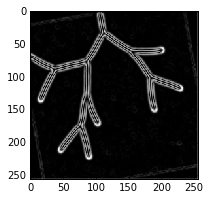

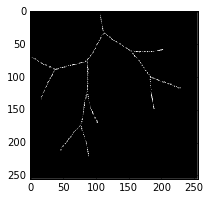

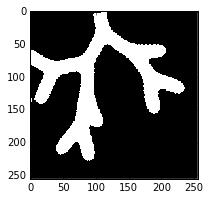

In [3]:
# V test load_toytreefeature_mat
plt.figure(figsize=(3, 3))
plt.imshow(np.linalg.norm(feature_vec_36, axis=2)[:, 12].reshape((256, 256)))

plt.figure(figsize=(3, 3))
plt.imshow(np.linalg.norm(GT_vec_36, axis=1).reshape((256, 256))) 

plt.figure(figsize=(3, 3))
plt.imshow(mask_vec_36.reshape((256, 256)))

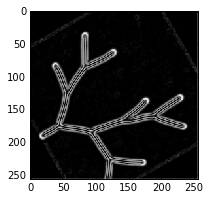

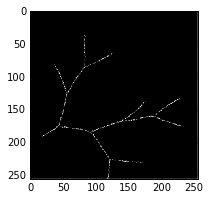

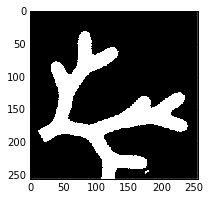

In [4]:
# V test load_toytreefeature_mat
plt.figure(figsize=(3, 3))
plt.imshow(np.linalg.norm(feature_vec_12, axis=2)[:, 12].reshape((256, 256)))

plt.figure(figsize=(3, 3))
plt.imshow(np.linalg.norm(GT_vec_12, axis=1).reshape((256, 256))) 

plt.figure(figsize=(3, 3))
plt.imshow(mask_vec_12.reshape((256, 256)))

In [5]:
# masking
m_feature_vec36 = feature_vec_36[mask_vec_36][:, 12:24]
m_GT_vec36 = GT_vec_36[mask_vec_36]
print m_feature_vec36.shape, m_GT_vec36.shape

m_feature_vec12 = feature_vec_12[mask_vec_12][:, 12:24]
m_GT_vec12 = GT_vec_12[mask_vec_12]
print m_feature_vec12.shape, m_GT_vec12.shape

# 正規化
normed_m_feature_vec36, normed_m_feature_vec12, norm_coef =\
    TN_utils.normalize_feature_vec(m_feature_vec36, m_feature_vec12)
    
# (batch_size, n_tensors, D) → (batch_size, D, n_tensors) T.tensordotなどの都合で
normed_m_feature_vec36_T = normed_m_feature_vec36.transpose(0, 2, 1)
normed_m_feature_vec36_T.shape

normed_m_feature_vec12_T = normed_m_feature_vec12.transpose(0, 2, 1)
normed_m_feature_vec12_T.shape

# permutate 
pnm_feature_vec_train, pm_gt_vec_train = TN_utils.permu_date_set(normed_m_feature_vec36_T, m_GT_vec36)
pnm_feature_vec_test, pm_gt_vec_test = TN_utils.permu_date_set(normed_m_feature_vec12_T, m_GT_vec12)

(13857, 12, 2) (13857, 2)
(13597, 12, 2) (13597, 2)


In [21]:
import theano_utils
reload(theano_utils)
import compiling
reload(compiling)
import models
reload(models)
import optimizers
reload(optimizers)

<module 'optimizers' from 'optimizers.pyc'>

In [28]:
rcn_3layer = models.Rcn3layer(n_tensors_list=[12, 10, 10], 
                            func_key_list=["l-retanh", "relu", "relu"],
                             l2_reg=0.0001)

0 0.00732513808202 0.00726480841652
10 0.00323933306885 0.00317361377583
20 0.00320611638543 0.00312873350623
30 0.00319645792368 0.00310043859028
40 0.00314215907961 0.0030753032982
50 0.00312981984988 0.00305385107841
60 0.00311007593933 0.00304821883102
70 0.00309565780437 0.00305858572852
80 0.00309456812831 0.0030460321842
90 0.00308848424454 0.00302230116725
100 0.00306042902375 0.00300052610199
110 0.00303996942665 0.00301062419159
120 0.00303801556346 0.00300139257207
130 0.00304121659888 0.00299445569551
140 0.0030337673526 0.00298734453199
150 0.00299346237239 0.00293964021518
160 0.00297136345782 0.002931617703
170 0.00295478623322 0.00292437121021
180 0.00294000155896 0.00292418316578
190 0.00293496710808 0.00293571432229
200 0.00293613370483 0.00291995683873
210 0.00295669392718 0.00291706076587
220 0.00294179886488 0.00292891881215
230 0.00294072140303 0.00290040558962
240 0.00290447365399 0.0028927432842
250 0.00290092430318 0.00289861338695
260 0.00299054985074 0.002967

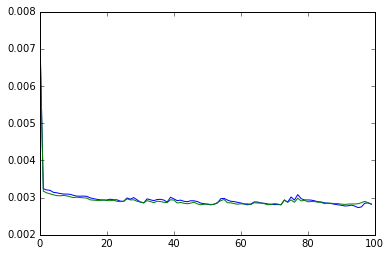

In [29]:
result = compiling.compile_graph(
    pnm_feature_vec_train, pm_gt_vec_train,
    pnm_feature_vec_test, pm_gt_vec_test,
    model=rcn_3layer,
    optimizer=optimizers.MomentumSGD())
f_train, f_training_error, f_test_error, f_output, s_input, s_target, param_list= result 

# さいしょにGTが０のdata pointに引っ張られて、全部真っ黒になる時がある
# そのときは errorは 0.008以上
lr = 0.5
residual_mu = 0.5

# 1000以下だとめっちゃ誤差大きくなる, 最初から全部で学習すると遅い
batch_size = 1000
N = s_input.get_value(borrow=True).shape[0]
n_batchs = N // batch_size

n_epochs = 1000
interval = 10
training_error_array = np.zeros((n_epochs // interval,))
test_error_array = np.zeros((n_epochs // interval,))

start = time.clock()
for i_epoch in xrange(n_epochs):
    for i_batch in xrange(n_batchs):
        f_train(i_batch, batch_size, lr, 0.99 - residual_mu)
        
    if i_epoch % interval == 0:
        lr = lr * 0.99  # lr decay
        residual_mu = residual_mu * 0.9
        
        batch_size = int(batch_size * 1.3) # batch_size大きくしていく 重要
        if batch_size > N:
            batch_size = N
        n_batchs = N // batch_size + 1
        
        training_error = f_training_error()[0]
        training_error_array[i_epoch // interval] = training_error
        test_error = f_test_error()[0]
        test_error_array[i_epoch // interval] = test_error
        print i_epoch, training_error, test_error
        
print time.clock() - start
# V
plt.plot(training_error_array)
plt.plot(test_error_array)

In [30]:
a = feature_vec_36[:, 12:24]/norm_coef[:, np.newaxis]
gt2_vec = f_output(a.transpose(0, 2, 1))[0]
gt1_img = TN_utils.convert_gt2vec_to_gt1img(gt2_vec, img_shape=(256, 256))

feature_vec_12 = TN_utils.load_featureImg_r(12)[:, 12:24]
b = feature_vec_12/norm_coef[:, np.newaxis]
gt2_vec_12 = f_output(b.transpose(0, 2, 1))[0]
gt1_img_12 = TN_utils.convert_gt2vec_to_gt1img(gt2_vec_12, img_shape=(256, 256))

In [11]:
import scipy.io as sio
sio.savemat("../tmp/gt1_train.mat", {"gt1_train": gt1_img})
sio.savemat("../tmp/gt1_test.mat", {"gt1_test": gt1_img_12})

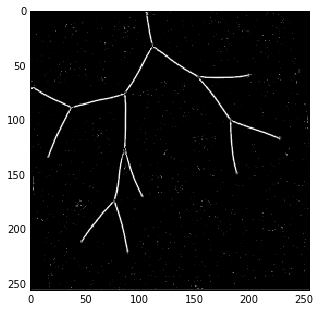

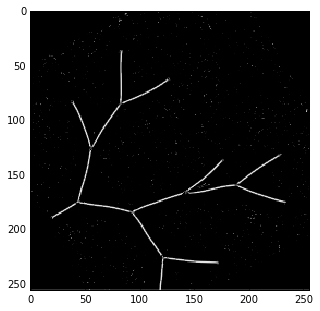

In [31]:
# V outputのノルムを見てる
plt.figure(figsize=(5, 5))
plt.imshow(np.linalg.norm(gt1_img, axis=0).T)
 
plt.figure(figsize=(5, 5))
plt.imshow(np.linalg.norm(gt1_img_12, axis=0).T)

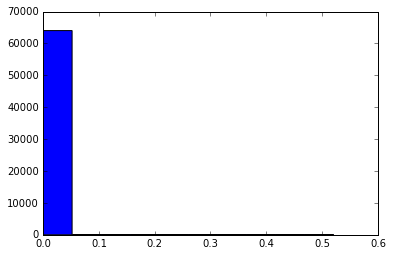

In [13]:
# V
gomi = plt.hist(np.linalg.norm(gt1_img, axis=0).flatten())

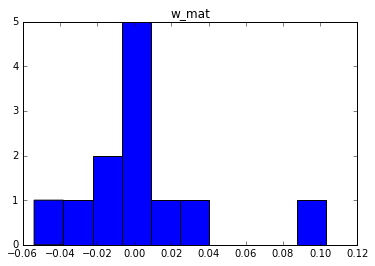

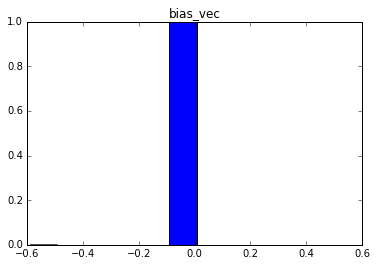

In [14]:
for i in range(len(param_list)):
    plt.figure()
    plt.title(param_list[i])
    plt.hist(param_list[i].get_value().flatten())

In [27]:
def power(x, rate, n):
    for i in range(n):
        x = x * rate
    return x

In [29]:
power(0.5, 1.01, 5)

0.52550502505

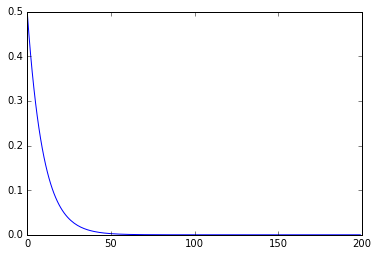

In [38]:
n_list = range(200)
plt.plot(n_list, [power(0.5, 0.9, n) for n in n_list])

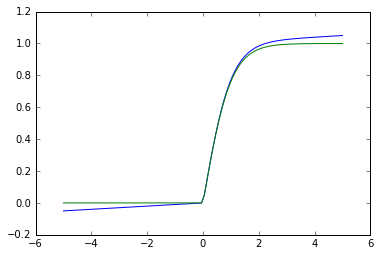

In [71]:
x = np.linspace(-5, 5, 100)
plt.plot(x, np.max([np.zeros(x.shape[0]), np.tanh(x)], axis=0) + 0.01*x)
plt.plot(x, np.max([np.zeros(x.shape[0]), np.tanh(x)], axis=0))

In [66]:
np.max?